In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import scqubits as scq
from scqubits import HilbertSpace, InteractionTerm, ParameterSweep

import numpy as np

np.set_printoptions(threshold=10, edgeitems=2)

In [5]:
# Define HilbertSpace object: two transmons coupled to an oscillator


tmon1 = scq.TunableTransmon(
    EJmax=40.0,
    EC=0.2,
    d=0.1,
    flux=0.23,
    ng=0.3,
    ncut=40,
    truncated_dim=3,     # after diagonalization, we will keep 3 levels
    id_str="tmon1"       # optional, used for referencing from within
                         # ParameterSweep or HilbertSpace
)

tmon2 = scq.TunableTransmon(
    EJmax=15.0,
    EC=0.15,
    d=0.2,
    flux=0.0,
    ng=0.0,
    ncut=30,
    truncated_dim=3,
    id_str="tmon2"
)

resonator = scq.Oscillator(
    E_osc=4.5,
    truncated_dim=4    # up to 3 photons (0,1,2,3)
)

hilbertspace = scq.HilbertSpace([tmon1, tmon2, resonator])


g1 = 0.1  # coupling resonator-CPB1 (without charge matrix elements)
g2 = 0.2  # coupling resonator-CPB2 (without charge matrix elements)

hilbertspace.add_interaction(
    g_strength = g1,
    op1 = tmon1.n_operator,
    op2 = resonator.creation_operator,
    add_hc = True,
    id_str="tmon1-resonator"  # optional keyword argument
)

hilbertspace.add_interaction(
    g_strength = g2,
    op1 = tmon2.n_operator,
    op2 = resonator.creation_operator,
    add_hc = True,
    id_str="tmon2-resonator"  # optional keyword argument
)

In [6]:
# Set up parameter name and values
pname1 = 'flux'  
flux_vals = np.linspace(0.0, 2.0, 171)
pname2 = 'ng'
ng_vals = np.linspace(-0.5, 0.5, 49)

# combine into a dictionary
paramvals_by_name = {pname1: flux_vals, pname2: ng_vals}


area_ratio = 1.2

def update_hilbertspace(flux, ng):  # function that defines how Hilbert space components are updated
    tmon1.flux = flux
    tmon2.flux = area_ratio * flux
    tmon2.ng = ng

# dictionary with information on which subsystems are affected by changing parameters    
subsys_update_info = {pname1: [tmon1, tmon2],
                      pname2: [tmon2]}

    
# create the ParameterSweep    
sweep = ParameterSweep(
    hilbertspace=hilbertspace,
    paramvals_by_name=paramvals_by_name,
    update_hilbertspace=update_hilbertspace,
    evals_count=20,
    subsys_update_info=subsys_update_info,
    num_cpus=4
)

Parallel compute bare eigensys for subsystem tmon1 [num_cpus=4]

Parallel compute bare eigensys for subsystem tmon2 [num_cpus=4]

Parallel compute bare eigensys for subsystem Oscillator_2 [num_cpus=4]

Parallel compute dressed eigensys [num_cpus=4]

## Working with `NamedSlotsNdarray`
### Parameter information
For convenience, `NamedSlotsNdarray` stores information about the parameters along with the array. Our array has the shape

In [7]:
sweep["evals"].shape

(171, 49, 20)

The associated parameters are obtained through the `NamedSlotsNdarray` attribute `param_info`:

In [8]:
sweep["evals"].param_info

OrderedDict([('flux',
              array([0.        , 0.01176471, ..., 1.98823529, 2.        ])),
             ('ng',
              array([-0.5       , -0.47916667, ...,  0.47916667,  0.5       ]))])

There are two names axes, one for the flux parameter, one for the offset charge parameter. The last (unnamed) axis is for the number of eigenvalues at each point (the default is 20).

The `param_info` entries are kept up-to-date upon slicing an `NamedSlotsNdarray`:

In [9]:
sliced_data = sweep["evals"][0, :]   # fix flux to the first parameter value and keep all ng values
print(sliced_data.shape)
print(sliced_data.param_info)

(49, 20)
OrderedDict([('ng', array([-0.5       , -0.47916667, ...,  0.47916667,  0.5       ]))])


Once all named axes have been collapsed, we return to an ordinary numpy array:

In [10]:
sweep["evals"][3, 5]

array([-48.62879419, -44.69222677, ..., -29.34186695, -28.71590343])

### Generalized slicing with NamedSlotsNdarray

#### Name-based slicing
While the order of axes in a `NamedSlotsNdarray` is maintained consistently, referring to an axis by its name can be convenient. In this name-based slicing, order of index entries does not matter:

In [11]:
(sweep["evals"]["flux":5, "ng":7], 
 sweep["evals"]["ng":7, "flux":5])

(array([-48.01009565, -44.09912786, ..., -28.83587136, -28.19100498]),
 array([-48.01009565, -44.09912786, ..., -28.83587136, -28.19100498]))

Name-based slicing allows for `start` and `stop`. For example, `["flux":3:-2]` chooses the flux parameter values from element 4 to the second-but-last element. (A `step` entry is not supported for name-based slicing.)

.. note::
    Name-based slicing and ordinary slicing by axes position cannot be mixed. If a multi-index contains a 
    name-based entry, then all entries must be name-based.  

#### Value-based slicing
Generalized slicing includes the possibility to refer to an array axis by a parameter value rather than through its index. One downside of this: the parameter value needs to be entered in full with all relevant decimals. This option therefore makes most sense when parameter value arrays are built commensurate with simple decimals.

Example: the ng value 0.0 is one value in the ng parameter array. We can access it via

In [12]:
sweep["evals"][:, 0.0]

NamedSlotsNdarray([[-48.9776994 , -45.02697343, ..., -29.62767069,
                    -29.01259019],
                   [-48.93884687, -44.98968522, ..., -29.59581918,
                    -28.97953529],
                   ...,
                   [-40.69998479, -38.210735  , ..., -23.6119997 ,
                    -22.82192523],
                   [-40.26251587, -37.8914427 , ..., -23.40840165,
                    -22.49727021]])

Value-based indexing will ordinarily fail if values entered do not match concrete values in the original array of values. This behavior can be changed in favor of more forgiving "fuzzy" value-based indexing which selects the closest value to the one entered. This is enabled by changing the default for `FUZZY_SLICING`:

In [13]:
scq.settings.FUZZY_SLICING = True
sweep["evals"]["ng":0.001]

 : 24

NamedSlotsNdarray([[-48.9776994 , -45.02697343, ..., -29.62767069,
                    -29.01259019],
                   [-48.93884687, -44.98968522, ..., -29.59581918,
                    -28.97953529],
                   ...,
                   [-40.69998479, -38.210735  , ..., -23.6119997 ,
                    -22.82192523],
                   [-40.26251587, -37.8914427 , ..., -23.40840165,
                    -22.49727021]])

Value-based and string-based slicing can be combined. The following thus produces the same result:

In [14]:
sweep["evals"]["ng":0.0]

NamedSlotsNdarray([[-48.9776994 , -45.02697343, ..., -29.62767069,
                    -29.01259019],
                   [-48.93884687, -44.98968522, ..., -29.59581918,
                    -28.97953529],
                   ...,
                   [-40.69998479, -38.210735  , ..., -23.6119997 ,
                    -22.82192523],
                   [-40.26251587, -37.8914427 , ..., -23.40840165,
                    -22.49727021]])

**Distinction between value-based and index-based slicing**. All integer entries in slicing are interpreted as index-based slicing, whereas floats are taken as value-based. Thus, `["flux":1.0]` is the flux value 1.0 (if existent), whereas `["flux":1]` is the second (!) entry in the flux values array.

Note: when using integer-valued parameters such as `ncut`, value-based slicing should not be used.

### Quick plotting of sweep data
Once a `NamedSlotsNdarray` is reduced to a single parameter axis, data can readily be plotted using the `plot()` method:

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='flux'>)

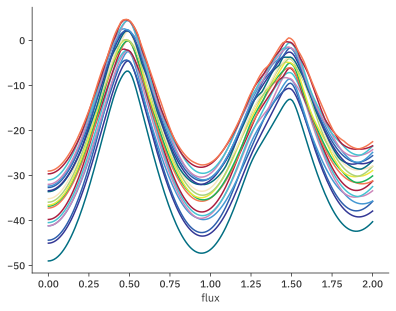

In [15]:
sweep["evals"][:,0].plot()

This result looks odd at first glance: where, for instance, is the flux-independent resonator line? The reason for the unfamiliar appearance is that we are plotting eigenvalues without subtracting the ground state energy. For that, see the `.transitions()` and `.plot_transitions()` methods in `ParameterSweep`.